**Aqui continuamos con el EDA ahora enfocados a la API de binance:**

**(NO INCLUIRÉ A LA CRIPTOMONEDA TETHER YA QUE BINANCE NO TIENE INFORMACION DEL PAR USDT/USD CON LO CUAL NOS QUEDAREMOS CON EL ANÁLISIS HECHO POR COINGENCKO PARA ESTA CRIPTOMONEDA)**<BR>

In [1]:
import requests
import numpy as np
import pandas as pd
import os


# Función para obtener datos históricos de una criptomoneda
def obtener_datos_historicos(criptomoneda):
    url = f"https://api.binance.com/api/v3/klines?symbol={criptomoneda}USDT&interval=1d&limit=1000"
    respuesta = requests.get(url)
    datos = respuesta.json()
    
    # Extraer los datos relevantes: Fecha, Precio de cierre, Volumen, Cap. de mercado (lo aproximamos usando el precio de cierre por volumen)
    fechas = [item[0] for item in datos]
    precios_cierre = [float(item[4]) for item in datos]
    volumenes = [float(item[7]) for item in datos]
    cap_mercado = [precio * volumen for precio, volumen in zip(precios_cierre, volumenes)]
    
    df = pd.DataFrame({
        'Fecha': fechas,
        'Precio_Cierre': precios_cierre,
        'Volumen_24h': volumenes,
        'Cap_Mercado': cap_mercado
    })
    
    return df


def obtener_nombre_completo(symbol):
    url = f"https://api.binance.com/api/v3/exchangeInfo"
    respuesta = requests.get(url)
    data = respuesta.json()

    for coin_info in data['symbols']:
        if coin_info['symbol'] == f"{symbol}USDT":
           
            return coin_info['baseAsset']  
    return None



# Función para calcular la volatilidad de 30 días
def calcular_volatilidad(precios):
    rendimientos = np.diff(np.log(precios))
    volatilidad = np.std(rendimientos) 
    return volatilidad

# Lista de criptomonedas
criptomonedas = ["BTC", "ETH", "XRP", "MATIC", "SOL", "ADA", "DOGE", "BNB", "DOT"]

# Diccionario para almacenar dataframes por criptomoneda
dataframes = {}

for moneda in criptomonedas:
    df = obtener_datos_historicos(moneda)
    
    # Calculo la volatilidad para cada fila del DataFrame y la agrego como nueva columna
    df['Volatilidad_30d'] = df['Precio_Cierre'].rolling(window=30).apply(calcular_volatilidad).round(3)

    df.fillna(0, inplace=True)

    # Convierto la columna de fecha en formato Unix a formato datetime
    df['Fecha'] = pd.to_datetime(df['Fecha'], unit='ms')

    # Convierto la fecha al formato deseado YY/MM/DD
    df['Fecha'] = df['Fecha'].dt.strftime('%y-%m-%d')

    # Guardo el DataFrame en el diccionario
    dataframes[moneda] = df



<strong>EDA: aqui realizo el análisis exploratorio visual y la detección de valores atípicos (outliers) de ciertos atributos de diferentes criptomonedas.</strong><br>

Importación de bibliotecas:<br>

matplotlib: para la visualización de gráficos.<br>
seaborn: otra herramienta de visualización que se construye sobre matplotlib y permite gráficos más atractivos y estadísticamente informados.<br>
scipy.stats: para obtener las puntuaciones Z (z-scores), que se usarán para la detección de outliers.<br>
numpy: para operaciones matemáticas y de arreglo.<br>

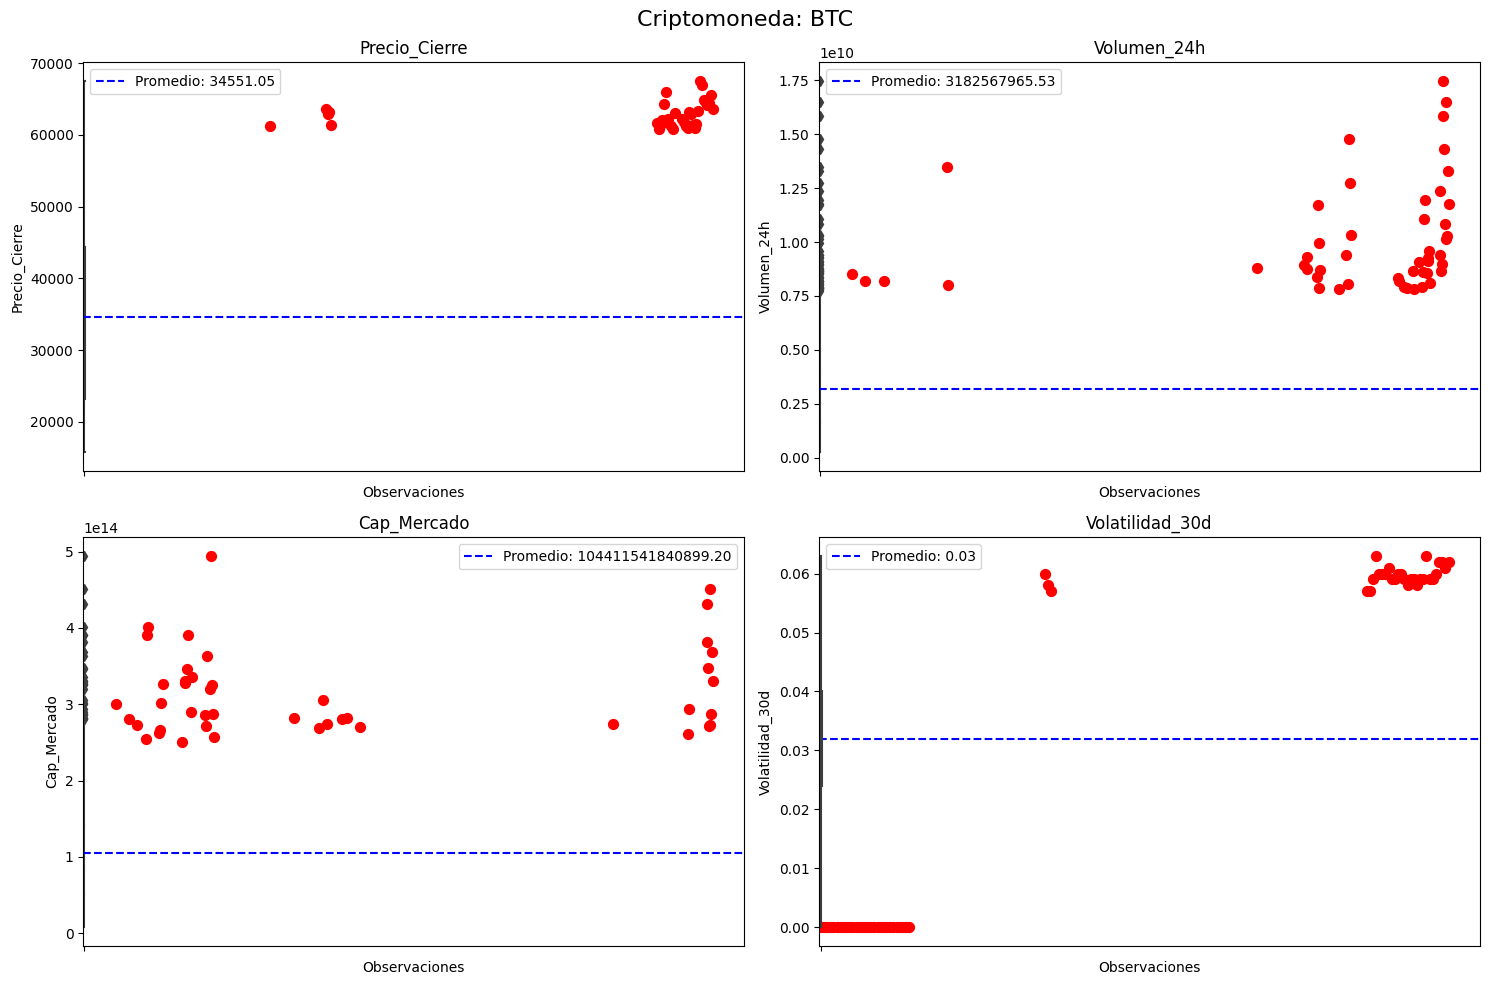

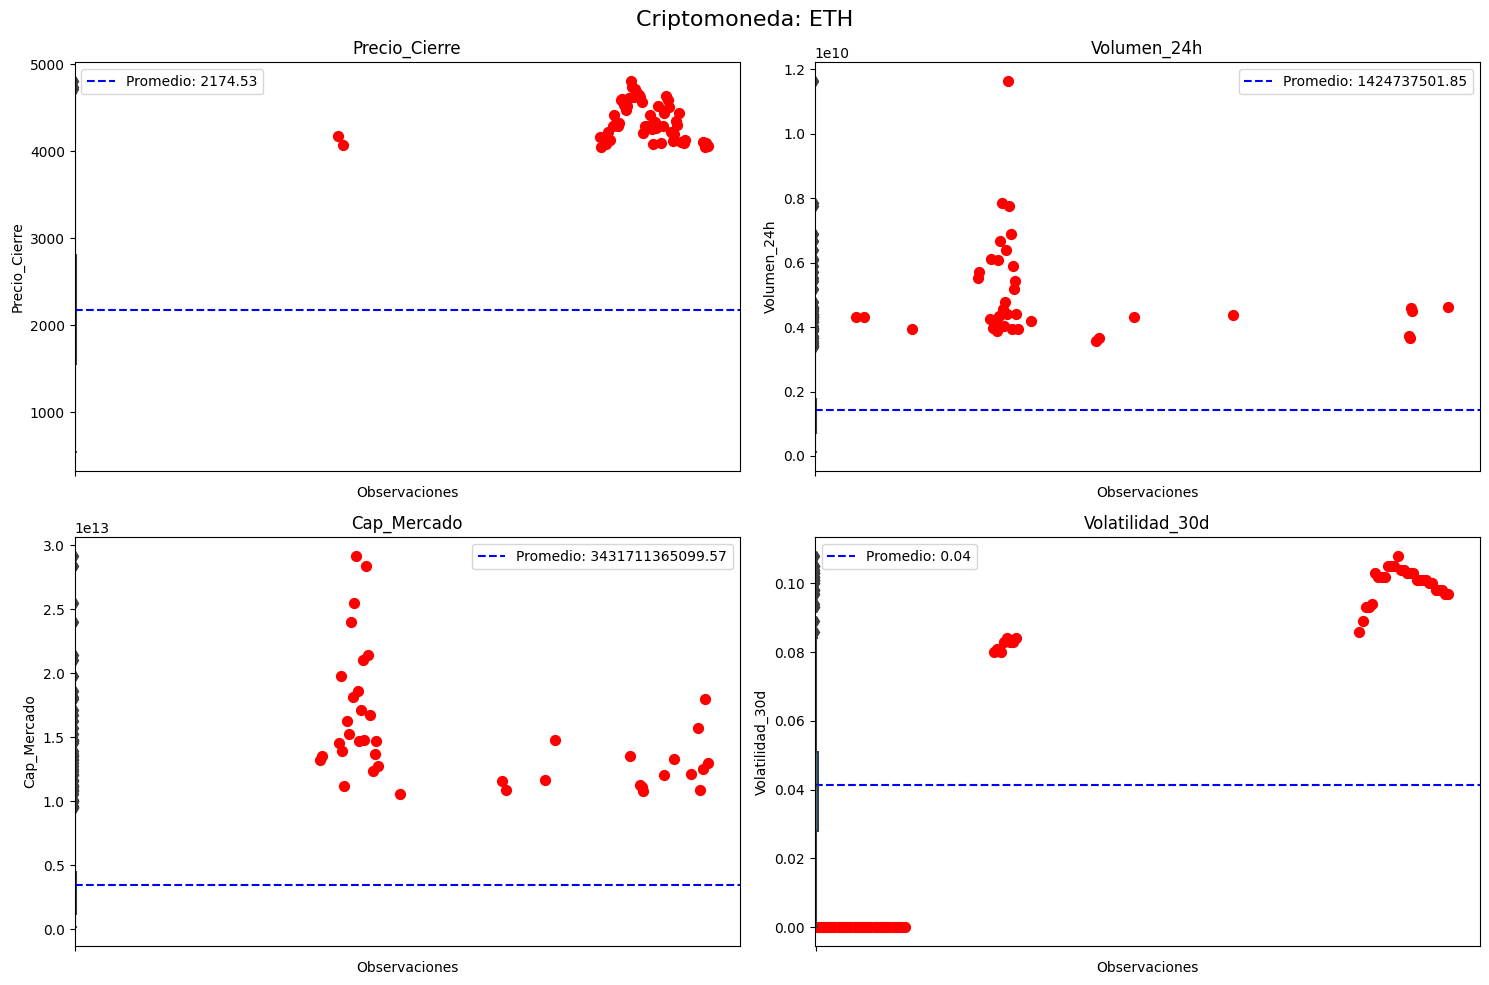

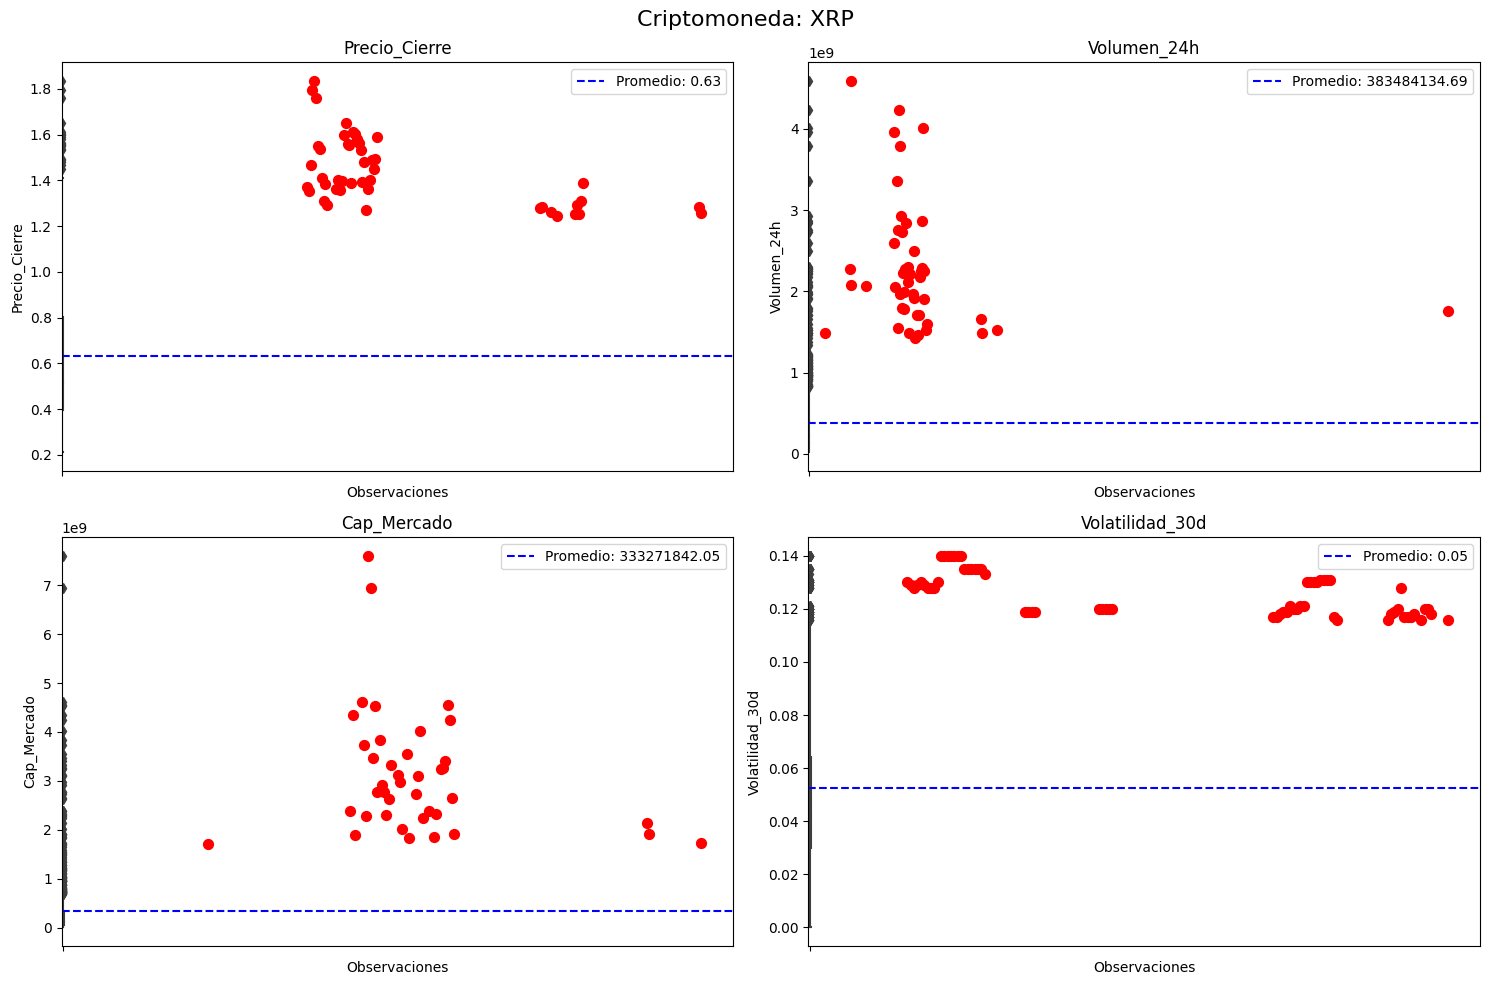

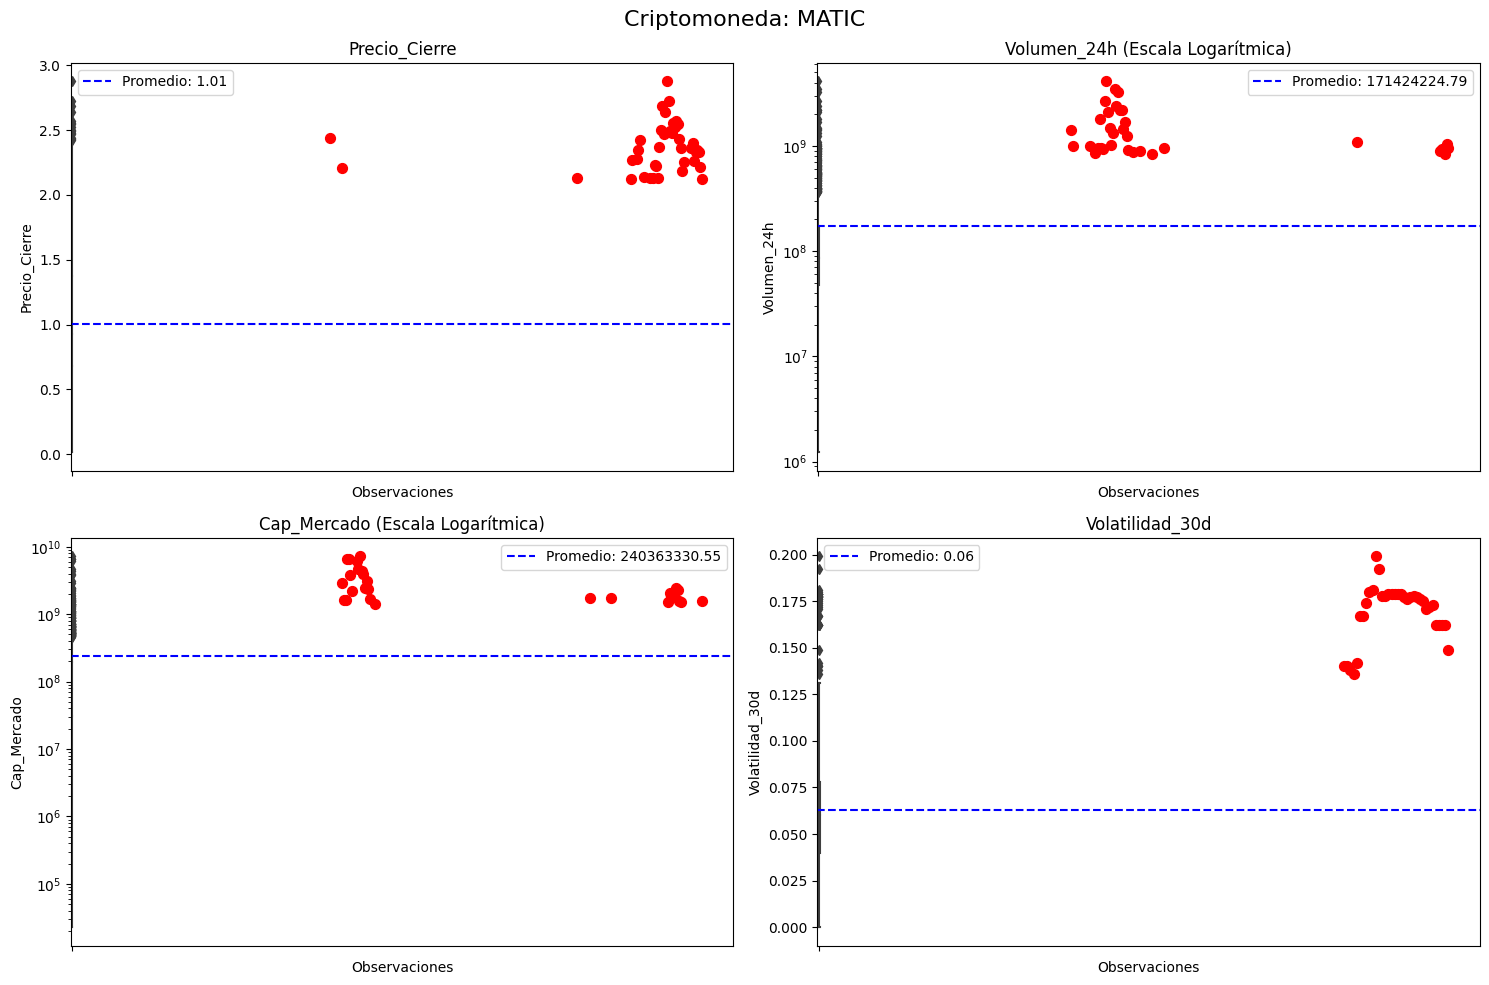

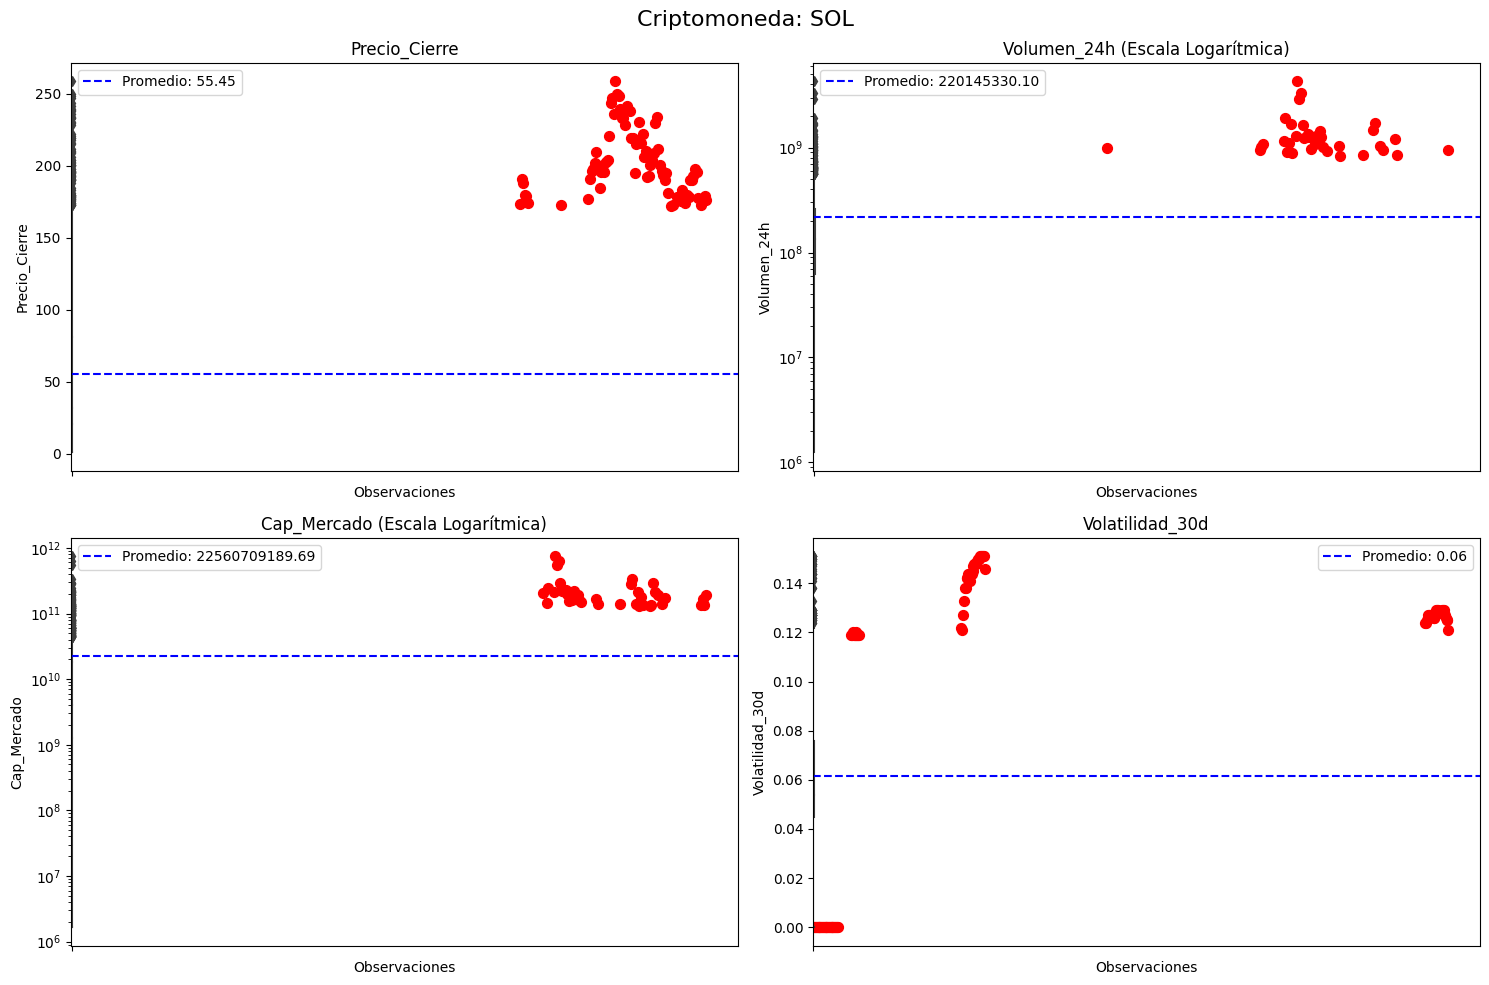

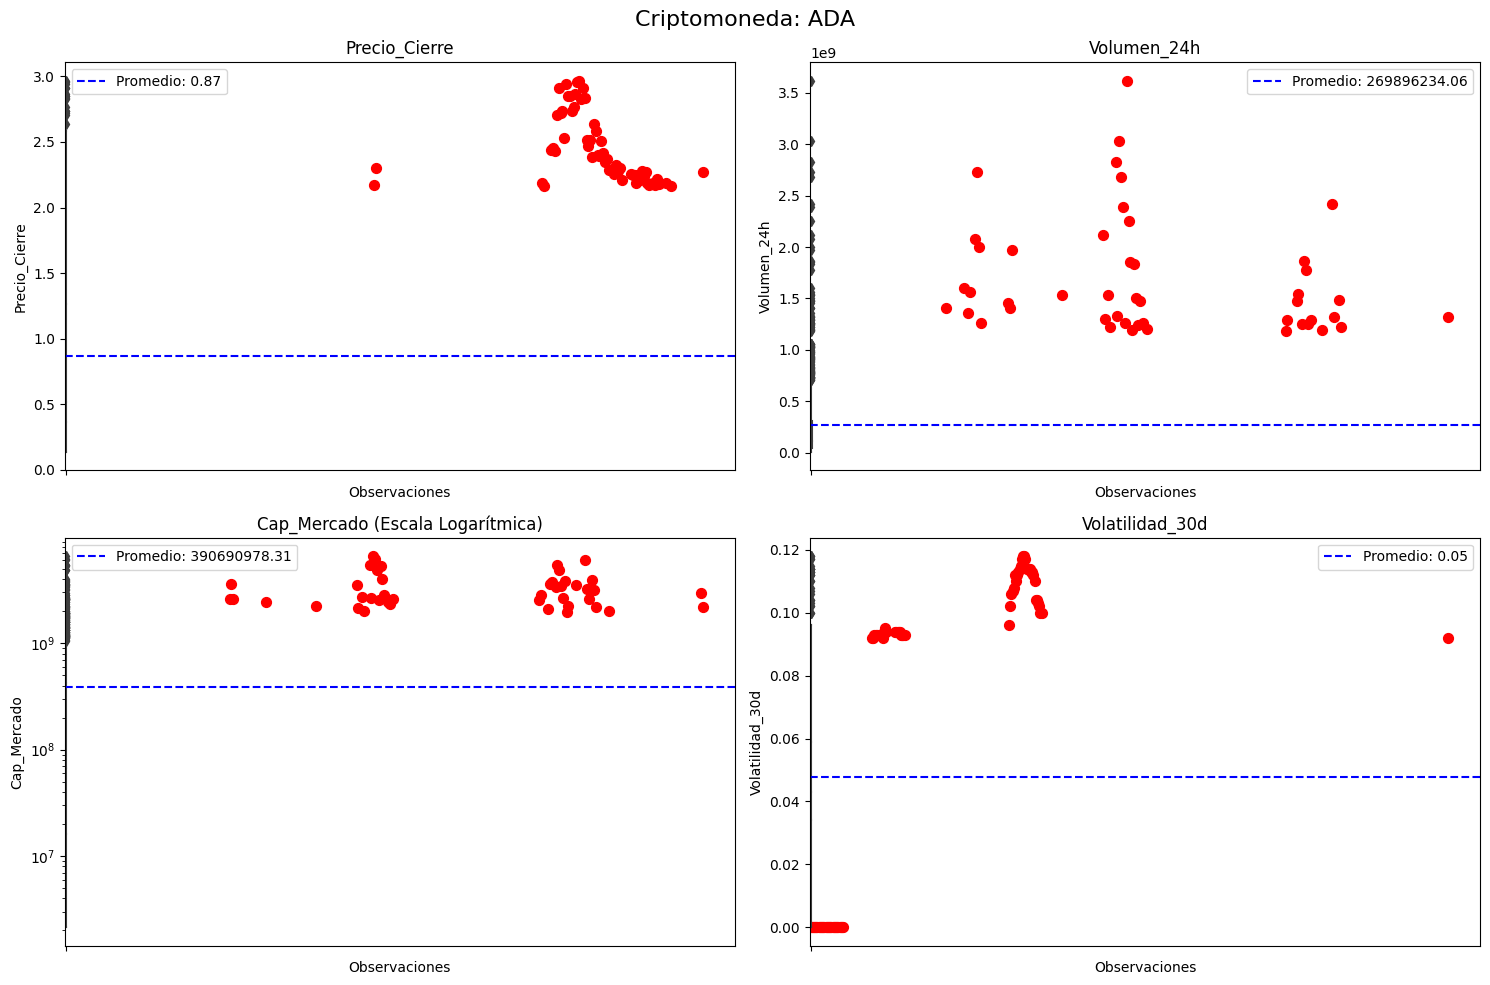

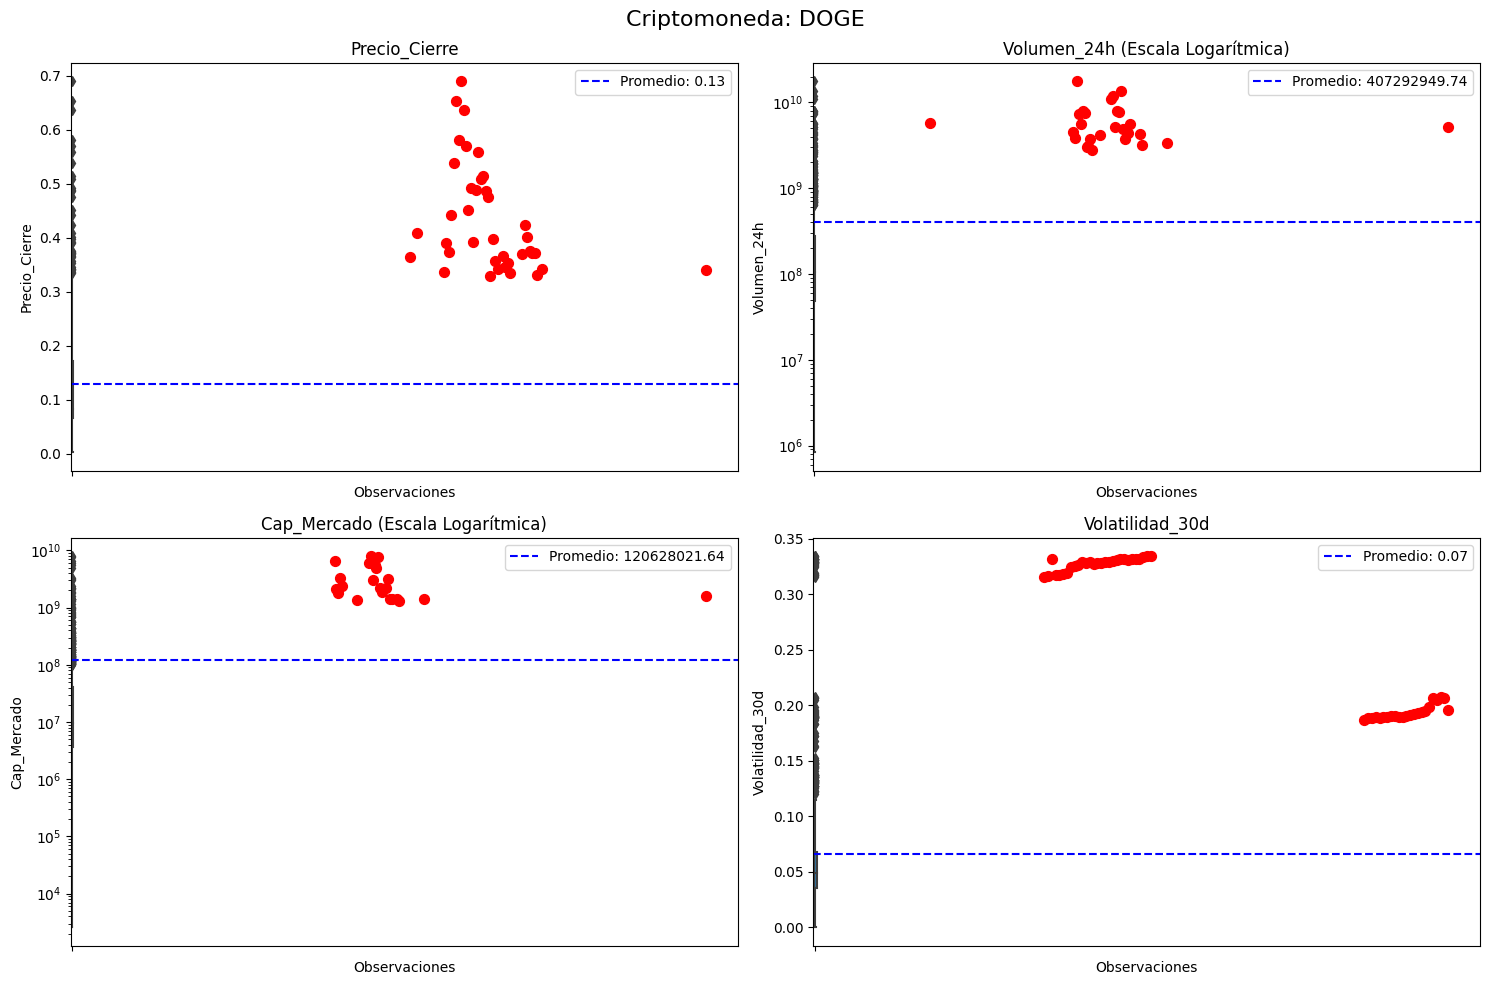

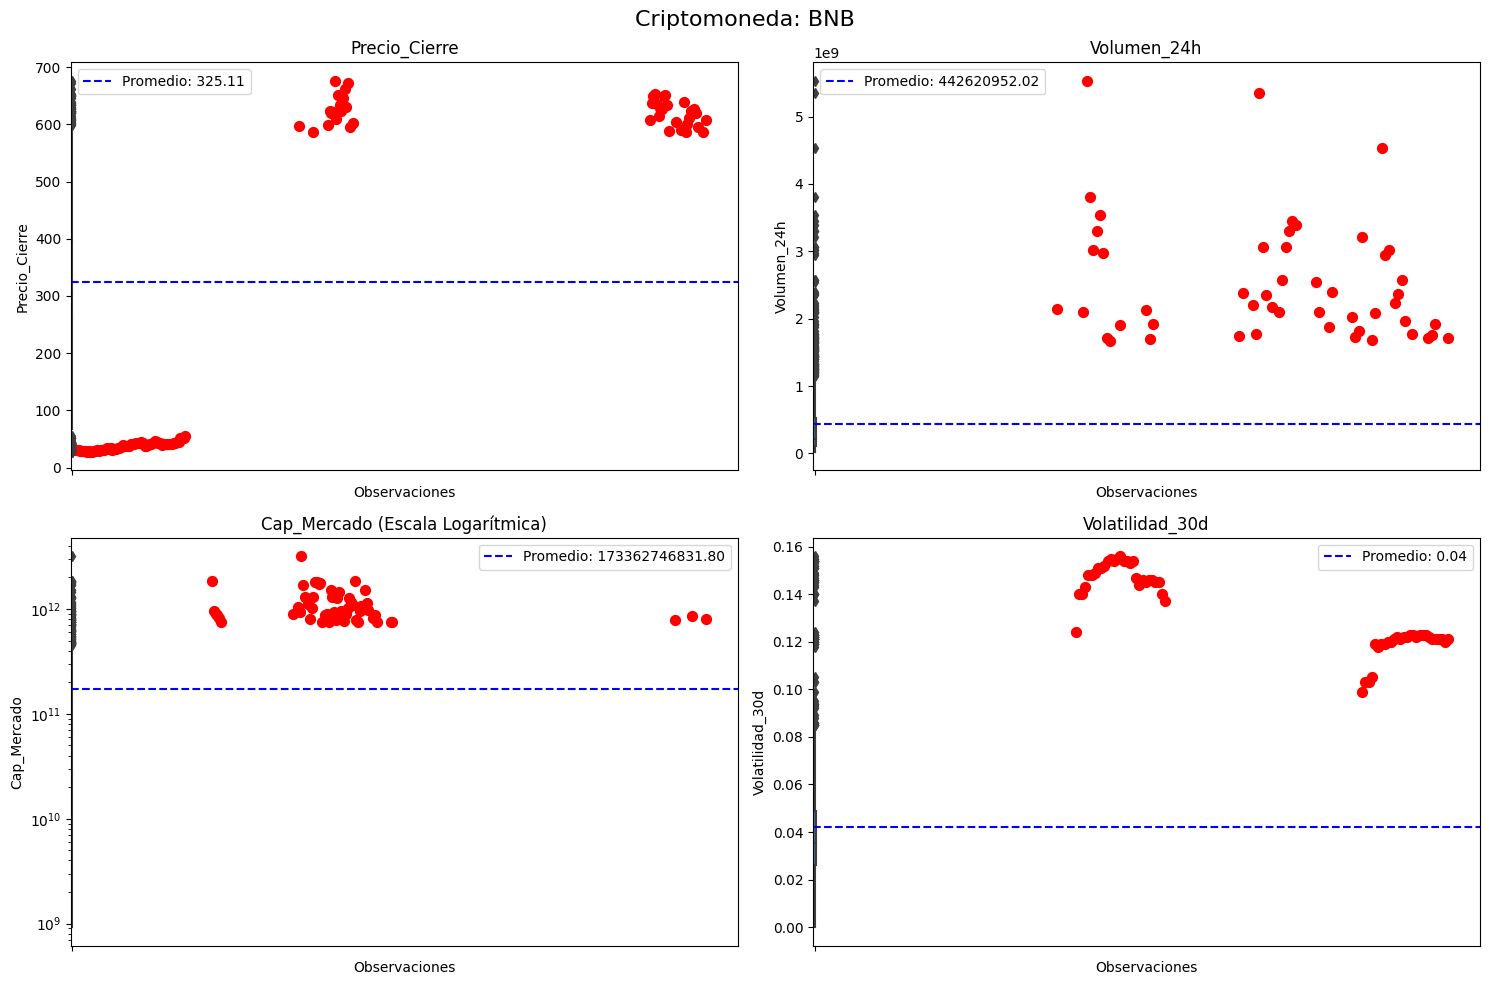

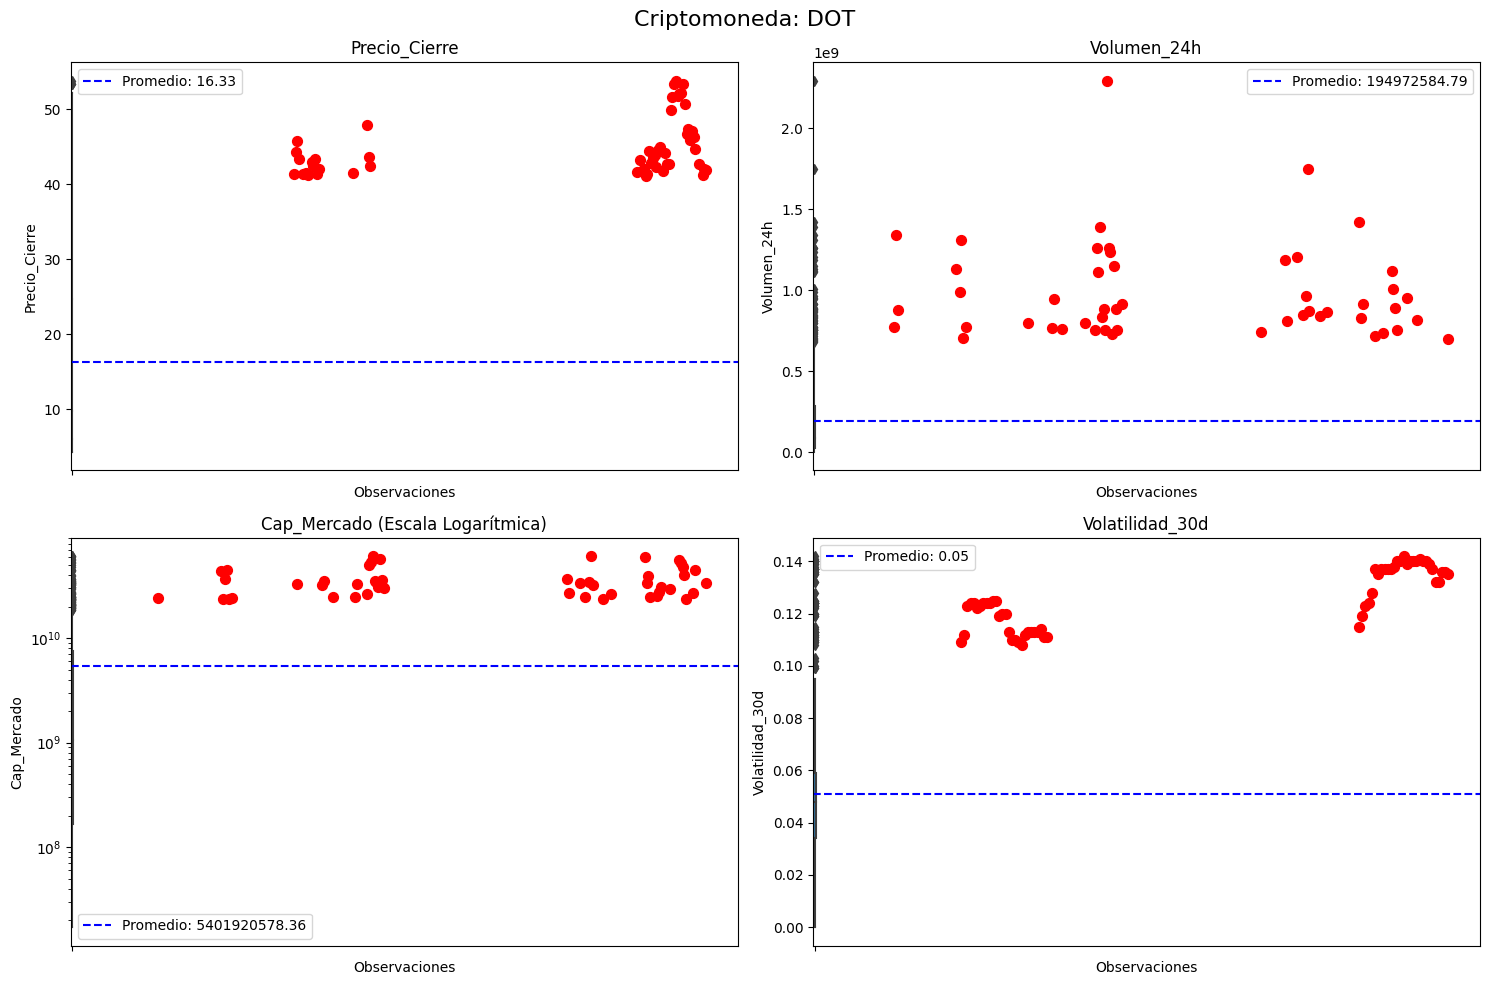

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Lista de columnas a analizar
columns_to_analyze = ['Precio_Cierre', 'Volumen_24h', 'Cap_Mercado', 'Volatilidad_30d']

for moneda, df in dataframes.items(): 
    
    # Convierto las columnas a numéricas y reemplazo valores no numéricos con 0
    for column in ['Volumen_24h', 'Cap_Mercado', 'Precio_Cierre']:
        df[column] = pd.to_numeric(df[column], errors='coerce')
        df[column].fillna(0, inplace=True)
    
    plt.figure(figsize=(15, 10))
    
    for i, column in enumerate(columns_to_analyze, 1):
        z_scores = stats.zscore(df[column])
        abs_z_scores = np.abs(z_scores)
        outliers = df[(abs_z_scores > 2)]
        
        ax = plt.subplot(2, 2, i)  # Creando 4 subplots: 2 filas y 2 columnas
        
        sns.boxplot(y=df[column], ax=ax)  # Nota: Cambiamos el boxplot para ser vertical
        
        # Agrego una línea horizontal para el valor promedio
        avg_value = df[column].mean()
        ax.axhline(y=avg_value, color='blue', linestyle='--', label=f"Promedio: {avg_value:.2f}")
        
        # Establecer escala logarítmica si los datos varían en varios órdenes de magnitud
        if df[column].min() > 0 and df[column].max() / df[column].min() > 1000:
            ax.set_yscale("log")
            plt.title(f"{column} (Escala Logarítmica)")
        else:
            plt.title(column)
        
        plt.xlabel("Observaciones")
        plt.ylabel(column)
        plt.scatter(outliers.index, outliers[column], color='red', s=50)  # Marca outliers en rojo
        plt.legend()  # Mostrar leyenda para el valor promedio
        
    # Mostrar información de la criptomoneda actual
    plt.suptitle(f"Criptomoneda: {moneda}", fontsize=16)
    plt.tight_layout()
    plt.show()


<strong>Conclusiones:<br>

Al igual que en los gráficos de la API coingecko Los Outliers que se ven en cada grafico son valores atípicos pero positivos,
 ya que o capitalizaron mas la criptomoneda en algun momento, eso significa que pudimos
vender en ciertos momento si hubiésemos invertido antes, pero ahora los valores estan dentro de los valores normales
en todas nuestras criptomonedas
La volatilidad tambien ahora esta en valores normales, pero cuando hubo mucha volatilidad fue por aumento del precio de la criptomoneda, no por valores depreciativos de la criptomoneda, y esto se repite en todas las criptomonedas elegidas
</strong>